In [1]:
# Importing required packages
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
# Setting up some options
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# Loading the data
train = pd.read_csv("data/train.csv")
df_test = pd.read_csv('data/test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
# Check for duplicates
print('Number of duplicated Id : ' + str(train.duplicated('Id').sum()))
print('Number of duplicated rows : ' + str(train.duplicated().sum()))

Number of duplicated Id : 0
Number of duplicated rows : 0


In [6]:
# Dropping Id column
train = train.drop('Id', axis = 1)

In [7]:
df_test_Id = df_test.Id
df_test = df_test.drop('Id', axis=1)

In [8]:
# Number of Numerical and Categorical columns
print('Number of categorical columns : ' + str(len(train.select_dtypes(include = ['object']).columns)))

print('Number of numerical columns : ' + str(len(train.select_dtypes(exclude = ['object']).columns)))

Number of categorical columns : 43
Number of numerical columns : 37


In [9]:
# Love for ggplot theme
plt.style.use('ggplot')

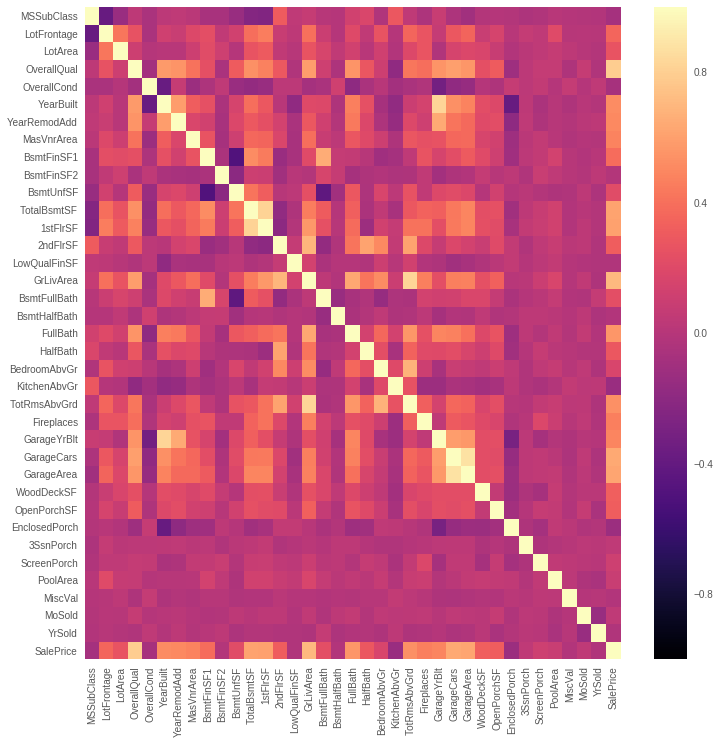

In [10]:
# Getting important features
train_corr = train.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(train_corr, robust = True, cmap = 'magma')

In [11]:
# Top 10 correlated features to SalePrice and their correlation matrix
print("Important featues using Correlation with SalePrice :")
train_corr.nlargest(11, 'SalePrice')['SalePrice']

Important featues using Correlation with SalePrice :


SalePrice      1.000
OverallQual    0.791
GrLivArea      0.709
GarageCars     0.640
GarageArea     0.623
TotalBsmtSF    0.614
1stFlrSF       0.606
FullBath       0.561
TotRmsAbvGrd   0.534
YearBuilt      0.523
YearRemodAdd   0.507
Name: SalePrice, dtype: float64

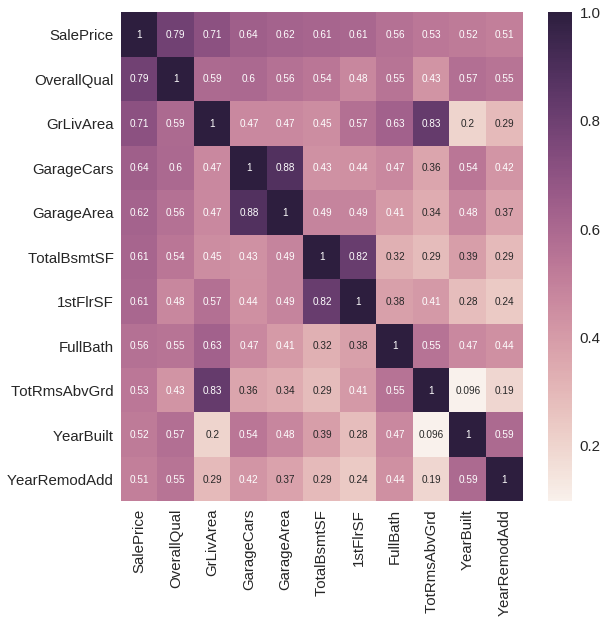

In [12]:
cols = train_corr.nlargest(11, 'SalePrice')['SalePrice'].index
corr_mat = np.corrcoef(train[cols].values.T)
plt.figure(figsize=(9, 9))
sns.set(font_scale=1.5)
sns.heatmap(corr_mat, annot = True, annot_kws={'size':10}, xticklabels=cols.values, yticklabels=cols.values)

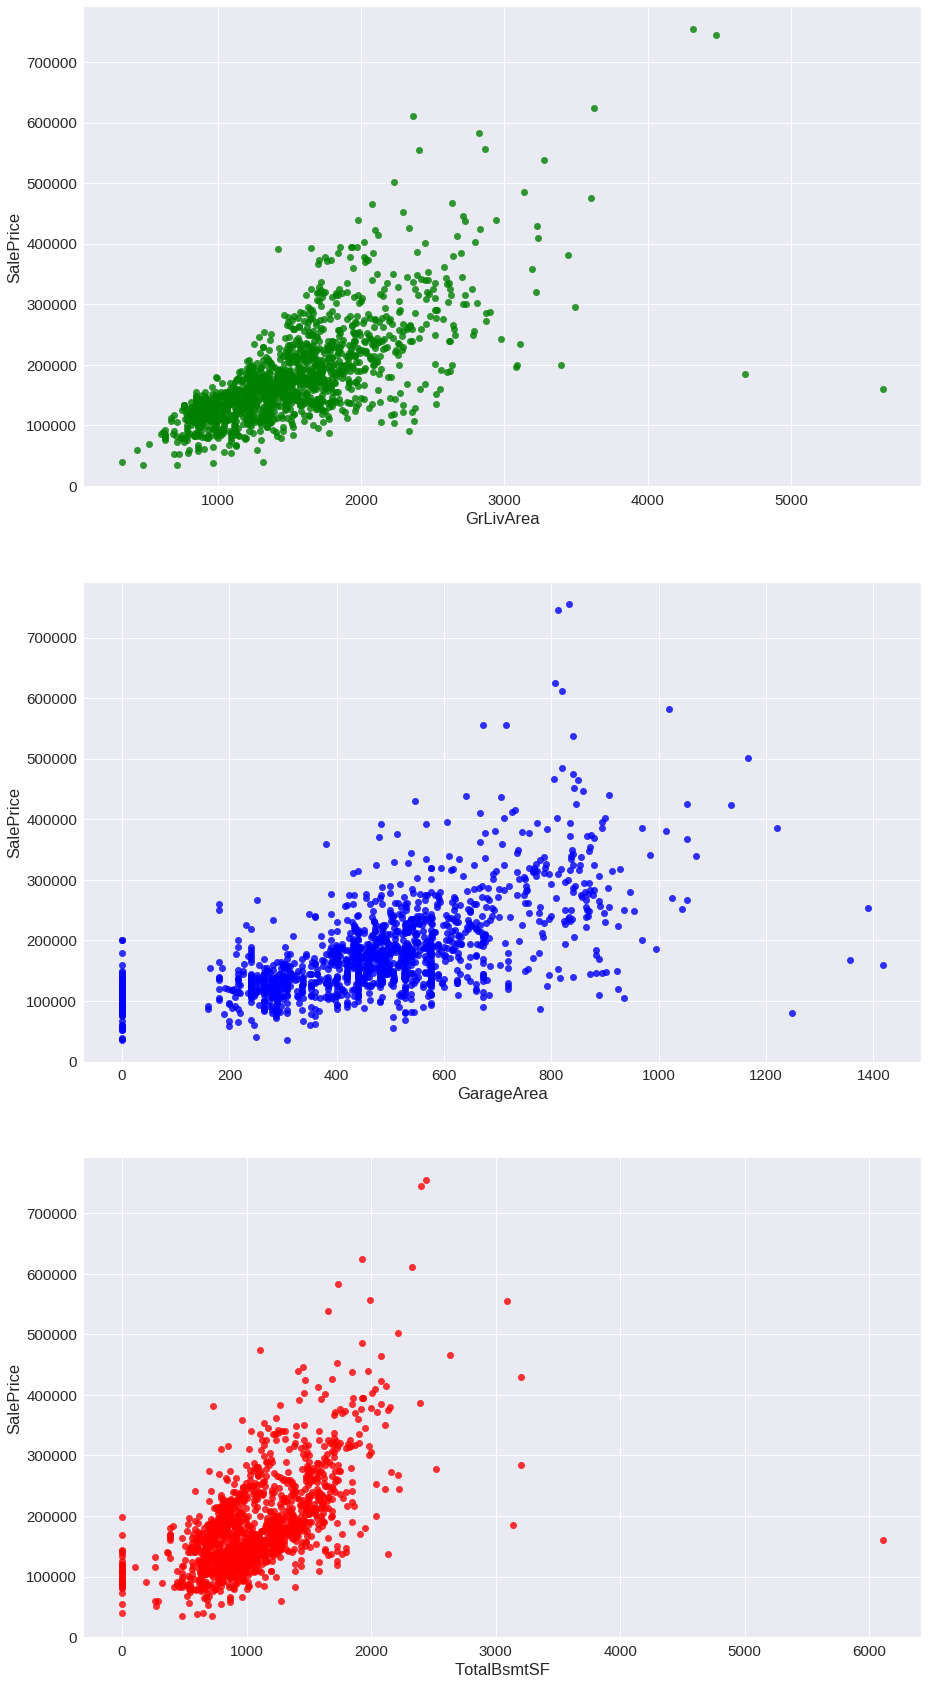

In [13]:
# Looking for outliers
figure = plt.figure(figsize=(15, 30))
plt.subplot(3,1,1)
sns.regplot(train['GrLivArea'], train['SalePrice'], fit_reg= False, color = 'green')
plt.subplot(3,1,2)
sns.regplot(train['GarageArea'], train['SalePrice'], fit_reg = False, color = 'blue')
plt.subplot(3,1,3)
sns.regplot(train['TotalBsmtSF'], train['SalePrice'], fit_reg = False, color = 'red')

In [14]:
# Removing two outlier data points
rm_index = train.sort_values(by = 'GrLivArea', ascending = False)['GrLivArea'].index[:4] ## using index of 4 largest values
train = train.drop(rm_index)

train = train[train.GarageArea < 1200] ## using range, better
train = train[train.TotalBsmtSF < 3000]

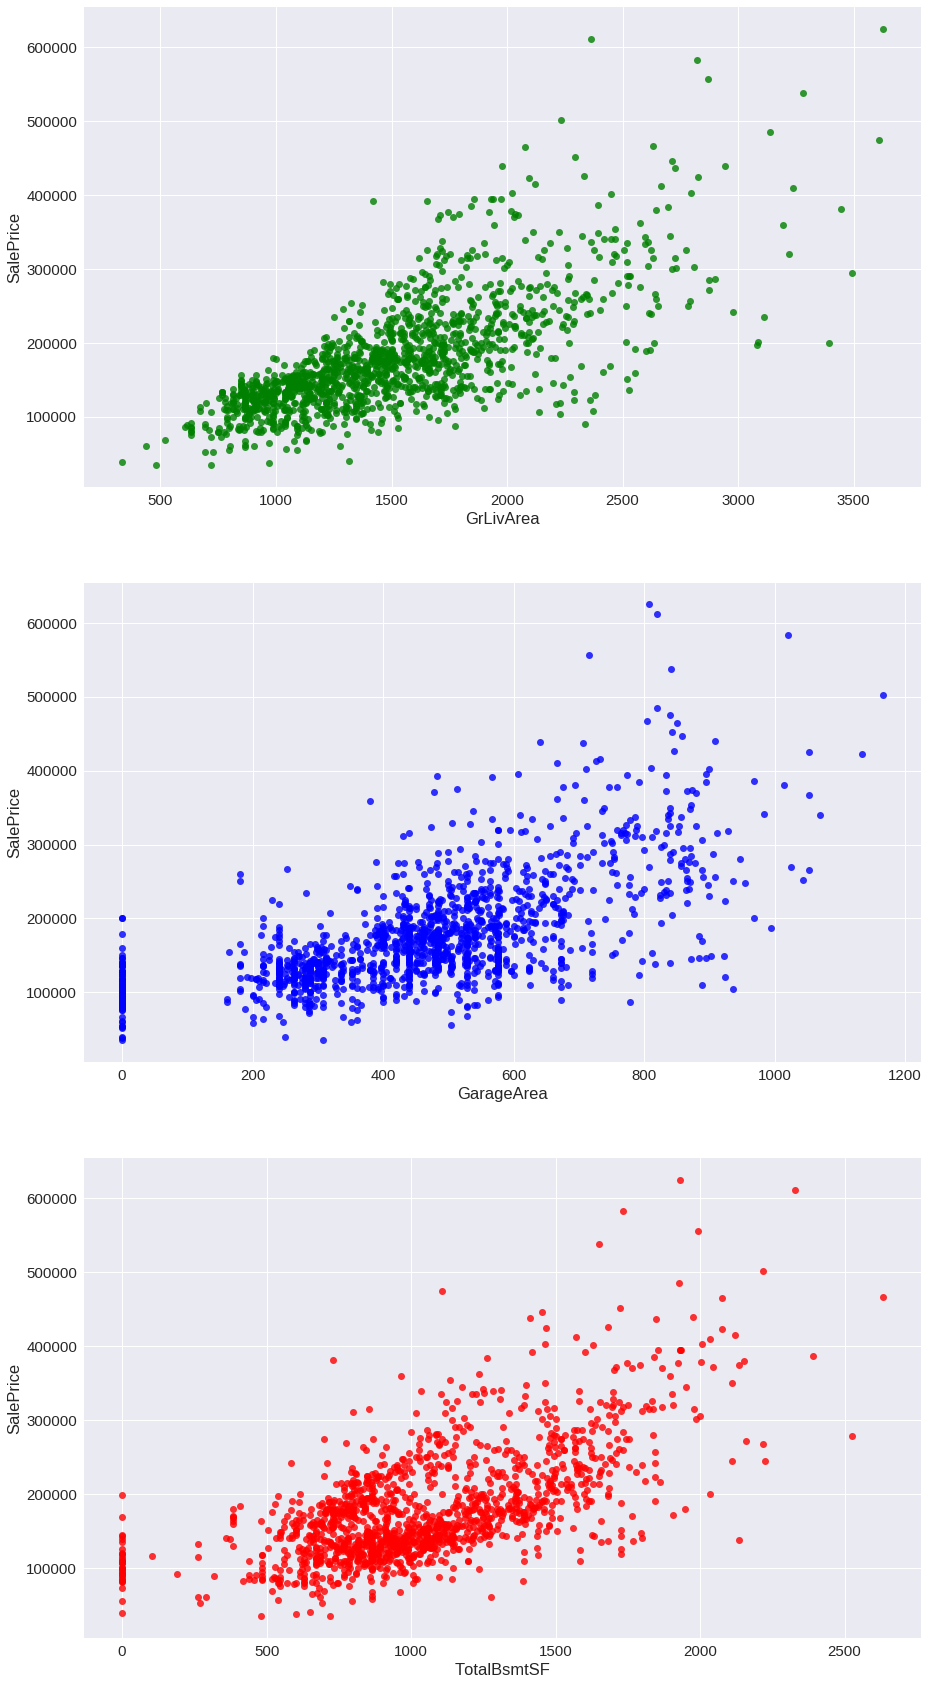

In [15]:
figure = plt.figure(figsize=(15, 30))
plt.subplot(3,1,1)
sns.regplot(train['GrLivArea'], train['SalePrice'], fit_reg= False, color = 'green')
plt.subplot(3,1,2)
sns.regplot(train['GarageArea'], train['SalePrice'], fit_reg = False, color = 'blue')
plt.subplot(3,1,3)
sns.regplot(train['TotalBsmtSF'], train['SalePrice'], fit_reg = False, color = 'red')

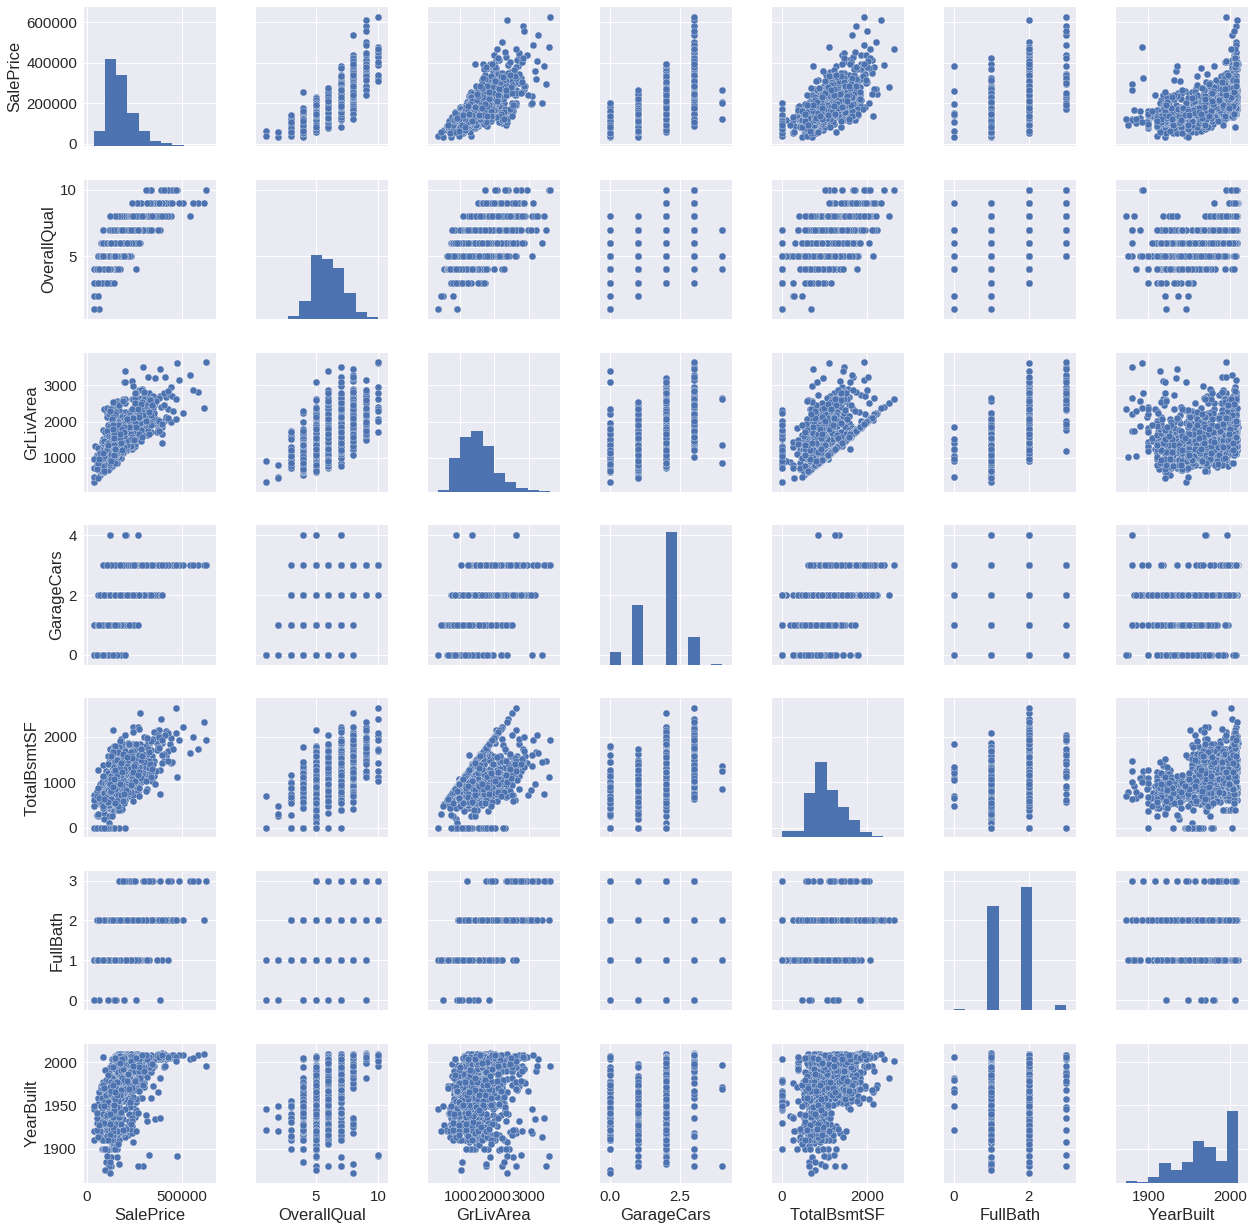

In [16]:
cols2 = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols2])

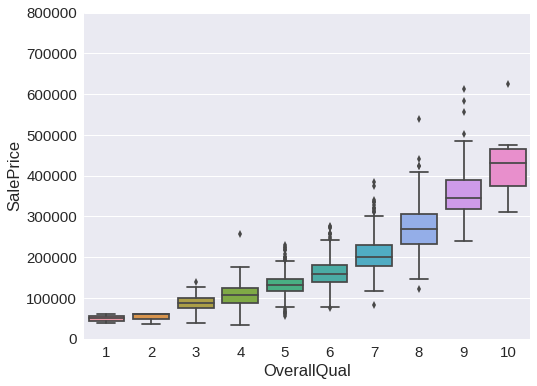

In [17]:
# Relationship with Categorical Variable
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
plt.figure(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

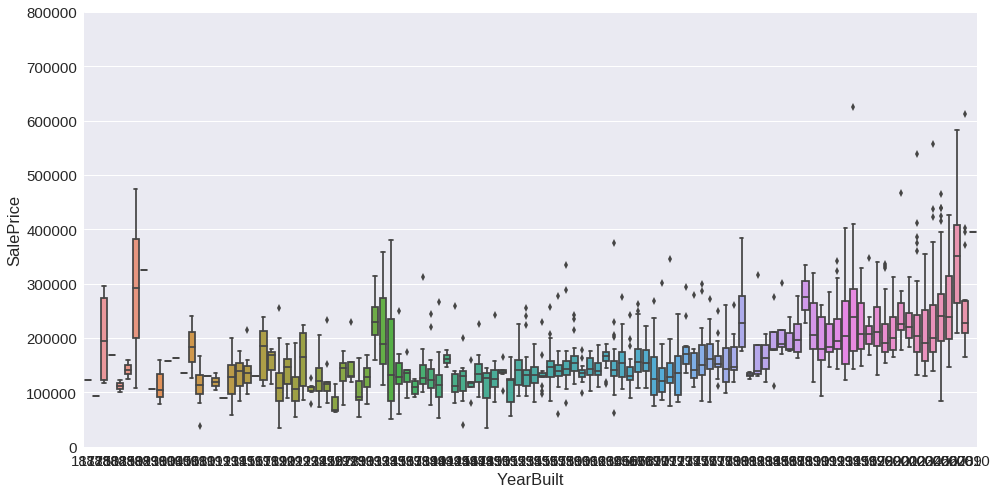

In [18]:
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
plt.figure(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [19]:
# Missing data analysis
missing = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum().sort_values(ascending = False) / len(train['SalePrice'])) * 100
missing_data = pd.concat([missing, percent], axis = 1, keys=['Missing', 'Percent'])
print(missing_data.loc[missing_data['Missing'].values > 0, :])

              Missing  Percent
PoolQC           1444   99.655
MiscFeature      1396   96.342
Alley            1358   93.720
Fence            1169   80.676
FireplaceQu       689   47.550
LotFrontage       257   17.736
GarageType         81    5.590
GarageCond         81    5.590
GarageFinish       81    5.590
GarageQual         81    5.590
GarageYrBlt        81    5.590
BsmtExposure       38    2.622
BsmtFinType2       37    2.553
BsmtQual           37    2.553
BsmtCond           37    2.553
BsmtFinType1       37    2.553
MasVnrArea          8    0.552
MasVnrType          8    0.552
Electrical          1    0.069


In [20]:
# Dropping Columns with missing values more that 90%
train.drop(['PoolQC', 'MiscFeature', 'Alley'], axis=1, inplace=True)

df_test.drop(['PoolQC', 'MiscFeature', 'Alley'], axis=1, inplace=True)

In [21]:
# Dropping row with NA values from Electrical column
train.dropna(subset=['Electrical'], inplace = True)

In [22]:
# Handle missing values for features where median/mean or most common value doesn't make sense

def handle_missing(train): 
    # BsmtQual etc : data description says NA for basement features is "no basement"
    train.BsmtQual = train.BsmtQual.fillna('No')
    train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
    train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
    train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
    train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
    # Fence : data description says NA means "no fence"
    train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")
    # FireplaceQu : data description says NA means "no fireplace"
    train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
    # GarageType etc : data description says NA for garage features is "no garage"
    train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
    train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
    train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
    train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
    train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
    train.loc[:, 'GarageYrBlt'] = train.loc[:, "GarageYrBlt"].fillna(0)
    # LotFrontage : NA most likely means no lot frontage
    train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
    # MasVnrType : NA most likely means no veneer
    train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
    
    return train
    
train = handle_missing(train)
df_test = handle_missing(df_test)

In [23]:
# Some numerical features are actually really categories
def num_to_cat(train):
    train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                           50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                           80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                           150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"}
    #                        "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
    #                                    7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                          })
    return train

train = num_to_cat(train)
df_test = num_to_cat(df_test)

In [24]:
# Encode some categorical features as ordered numbers when there is information in the order
def cat_to_num(train):
    train = train.replace({"BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                           "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                             "ALQ" : 5, "GLQ" : 6},
                           "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                             "ALQ" : 5, "GLQ" : 6},
                           "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                           "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                           "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                           "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                           "Min2" : 6, "Min1" : 7, "Typ" : 8},
                           "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                           "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                           "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                           "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                           "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                           "Street" : {"Grvl" : 1, "Pave" : 2},
                           "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                         )
    return train

train = cat_to_num(train)
df_test = cat_to_num(df_test)

In [25]:
def simplification_combination(train):
    # 1) Simplifications of existing features
    train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })
    train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })
    train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                         2 : 1, 3 : 1, # average
                                                         4 : 2, 5 : 2 # good
                                                        })
    train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                         2 : 1, 3 : 1, # average
                                                         4 : 2, 5 : 2 # good
                                                        })
    train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          })
    train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          })
    train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                         3 : 2, 4 : 2, # major
                                                         5 : 3, 6 : 3, 7 : 3, # minor
                                                         8 : 4 # typical
                                                        })
    train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          })
    train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
    train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                             2 : 1, 3 : 1, # rec room
                                                             4 : 2, 5 : 2, 6 : 2 # living quarters
                                                            })
    train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                             2 : 1, 3 : 1, # rec room
                                                             4 : 2, 5 : 2, 6 : 2 # living quarters
                                                            })
    train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
    train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
    train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
    train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })

    # 2) Combinations of existing features
    # Overall quality of the house
    train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
    # Overall quality of the garage
    train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
    # Overall quality of the exterior
    train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
    # Overall kitchen score
    train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
    # Overall fireplace score
    train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
    # Overall garage score
    train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
    # Simplified overall quality of the house
    train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
    # Simplified overall quality of the exterior
    train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]
    # Simplified overall garage score
    train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
    # Simplified overall fireplace score
    train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
    # Simplified overall kitchen score
    train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
    # Total number of bathrooms
    train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
    train["FullBath"] + (0.5 * train["HalfBath"])
    # Total SF for house (incl. basement)
    train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
    # Total SF for 1st + 2nd floors
    train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
    # Total SF for porch
    train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
    train["3SsnPorch"] + train["ScreenPorch"]
    # Has masonry veneer or not
    train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                                   "Stone" : 1, "None" : 0})
    # House completed before sale or not
    train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                          "Family" : 0, "Normal" : 0, "Partial" : 1})
    
    return train

train = simplification_combination(train)
df_test = simplification_combination(df_test)

In [26]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values("SalePrice", ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice              1.000
AllSF                  0.818
OverallQual            0.799
AllFlrsSF              0.728
GrLivArea              0.719
ExterQual              0.691
SimplOverallQual       0.677
KitchenQual            0.665
GarageCars             0.655
GarageScore            0.652
GarageArea             0.651
TotalBsmtSF            0.638
TotalBath              0.635
SimplGarageScore       0.628
SimplExterQual         0.626
1stFlrSF               0.616
BsmtQual               0.591
SimplKitchenQual       0.583
ExterGrade             0.583
OverallGrade           0.565
FullBath               0.558
SimplBsmtQual          0.545
YearBuilt              0.535
TotRmsAbvGrd           0.534
FireplaceQu            0.527
YearRemodAdd           0.522
FireplaceScore         0.506
SimplFireplaceQu       0.502
SimplKitchenScore      0.501
SimplFireplaceScore    0.487
                       ...  
SimplGarageCond        0.224
BsmtCond               0

In [27]:
# Create new features
def poly_features(train):
    # 3) Polynomials on the top 10 existing features
    train["OverallQual-s2"] = train["OverallQual"] ** 2
    train["OverallQual-s3"] = train["OverallQual"] ** 3
    train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
    train["AllSF-s2"] = train["AllSF"] ** 2
    train["AllSF-s3"] = train["AllSF"] ** 3
    train["AllSF-Sq"] = np.sqrt(train["AllSF"])
    train["AllFlrsSF-s2"] = train["AllFlrsSF"] ** 2
    train["AllFlrsSF-s3"] = train["AllFlrsSF"] ** 3
    train["AllFlrsSF-Sq"] = np.sqrt(train["AllFlrsSF"])
    train["GrLivArea-s2"] = train["GrLivArea"] ** 2
    train["GrLivArea-s3"] = train["GrLivArea"] ** 3
    train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])
    train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
    train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
    train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])
    train["ExterQual-s2"] = train["ExterQual"] ** 2
    train["ExterQual-s3"] = train["ExterQual"] ** 3
    train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])
    train["GarageCars-s2"] = train["GarageCars"] ** 2
    train["GarageCars-s3"] = train["GarageCars"] ** 3
    train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])
    train["TotalBath-s2"] = train["TotalBath"] ** 2
    train["TotalBath-s3"] = train["TotalBath"] ** 3
    train["TotalBath-Sq"] = np.sqrt(train["TotalBath"])
    train["KitchenQual-s2"] = train["KitchenQual"] ** 2
    train["KitchenQual-s3"] = train["KitchenQual"] ** 3
    train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])
    train["GarageScore-s2"] = train["GarageScore"] ** 2
    train["GarageScore-s3"] = train["GarageScore"] ** 3
    train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])
    
    return train

train = poly_features(train)
df_test = poly_features(df_test)

In [28]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns

numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

# training data
train_num = train[numerical_features]
train_cat = train[categorical_features]

# test data
df_test_num = df_test[numerical_features]
df_test_cat = df_test[categorical_features]

Numerical features : 114
Categorical features : 23


In [29]:
# Filling NA values in categorical variables using mod value

na_columns = df_test_cat.columns[df_test_cat.isnull().sum() > 0]
for column in na_columns:
    df_test_cat[column].fillna(df_test_cat[column].describe().freq, inplace = True)

In [30]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
print("NAs for numerical features in test : " + str(df_test_num.isnull().values.sum()))

train_num = train_num.fillna(train_num.median())
df_test_num = df_test_num.fillna(df_test_num.median())

print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
print("Remaining NAs for numerical features in test : " + str(df_test_num.isnull().values.sum()))

NAs for numerical features in train : 8
NAs for numerical features in test : 52
Remaining NAs for numerical features in train : 0
Remaining NAs for numerical features in test : 0


In [31]:
# Log transform of the skewed numerical features to lessen impact of outliers
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed

#glitch

def skew_to_log(train_num):
    skewness = train_num.apply(lambda x: skew(x))
    skewness = skewness[abs(skewness) > 0.5]
    print(str(skewness.shape[0]) + " skewed numerical features to log transform")
    skewed_features = skewness.index
    train_num[skewed_features] = np.log1p(train_num[skewed_features])
    
    return train_num

train_num = skew_to_log(train_num)
df_test_num = skew_to_log(df_test_num)

82 skewed numerical features to log transform
83 skewed numerical features to log transform


In [32]:
# Create dummy features for categorical values via one-hot encoding
def dummies(train_cat):
    print("NAs for categorical features: " + str(train_cat.isnull().values.sum()))
    train_cat = pd.get_dummies(train_cat)
    print("Remaining NAs for categorical features: " + str(train_cat.isnull().values.sum()))
    
    return train_cat

train_cat = dummies(train_cat)
df_test_cat = dummies(df_test_cat)

NAs for categorical features: 0
Remaining NAs for categorical features: 0
NAs for categorical features: 0
Remaining NAs for categorical features: 0


In [33]:
len(df_test_cat.columns)

174

In [34]:
# Log transform the target for official scoring
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

In [35]:
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)
df_test = pd.concat([df_test_num, df_test_cat], axis=1)
print("New number of features in training data : " + str(train.shape[1]))
print('New number of featues in testing data:' + str(df_test.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features in training data : 295
New number of featues in testing data:288
X_train : (1013, 295)
X_test : (435, 295)
y_train : (1013,)
y_test : (435,)


In [36]:
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

In [37]:
vec = X_test.Utilities > 0
X_test = X_test[vec]
y_test = y_test[vec]

vec = X_train.Utilities > 0
X_train = X_train[vec]
y_train = y_train[vec]

In [38]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(abs(cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10)))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(abs(cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10)))
    return(rmse)

**1) Linear Regression without regularization**

RMSE on the training set : 19296666.119354106
RMSE on the validation set : 0.38656977006123594


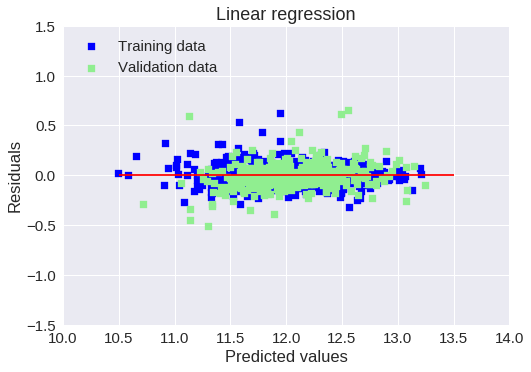

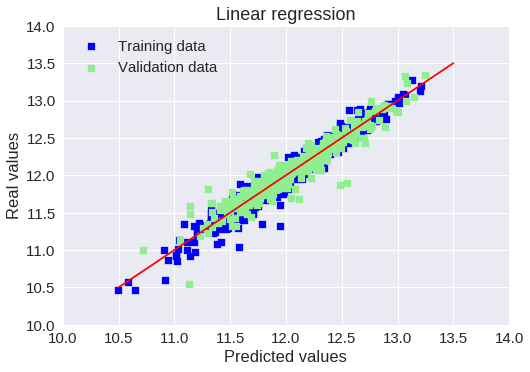

In [39]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
y_train_pred = lr.predict(X_train)
# Look at predictions on training and validation set
print('RMSE on the training set : ' + str(rmse_cv_train(lr).mean()))
print('RMSE on the validation set : ' + str(rmse_cv_test(lr).mean()))

# Residual plot
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.xlim(10, 14)
plt.ylim(-1.5, 1.5)
plt.show()


# Plot predictions

plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.xlim(10, 14)
plt.ylim(10, 14)
plt.show()


**2) Linear Regression with Ridge Regression**

Best alpha: 10.0
Searching for better value for alpha near above mentioned value.
Best alpha: 8.5
Ridge RMSE on Training set : 0.11357354944656187
Ridge RMSE on Test set : 0.11130349748382909


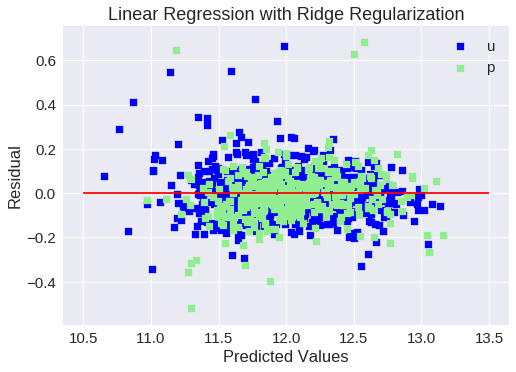

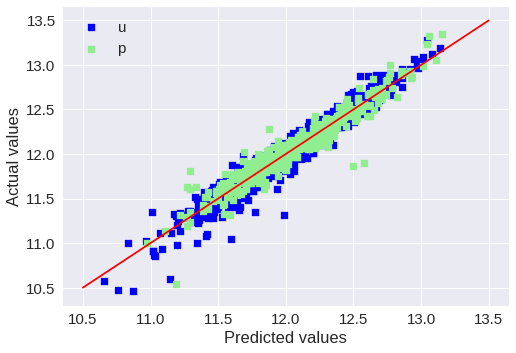

Ridge picked 290 features and eliminated other 5


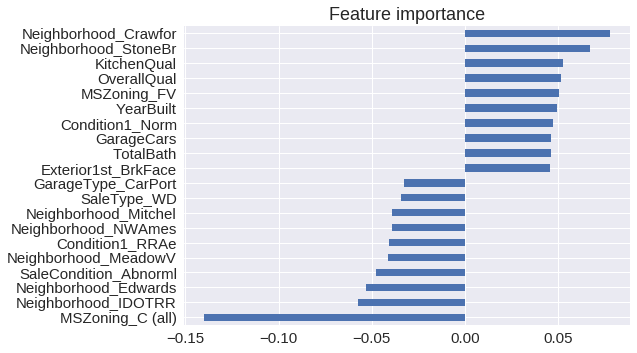

In [40]:
ridge = RidgeCV(alphas= (0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60))
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha: " + str(alpha))

print('Searching for better value for alpha near above mentioned value.')
ridge = RidgeCV(alphas=(alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4), cv=10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print('Best alpha: ' + str(alpha))

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Residual plot
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = 'blue', marker = 's', label = 'Training data')
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = 'lightgreen', marker = 's', label = 'Test data')
plt.title('Linear Regression with Ridge Regularization')
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.legend('upper left')
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = 'blue', marker = 's', label = 'Training data')
plt.scatter(y_test_rdg, y_test, c = 'lightgreen', marker = 's', label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.legend('upper left')
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Feature importance
coefs = pd.Series(ridge.coef_, index=X_train.columns)
print('Ridge picked ' + str(sum(coefs != 0)) + ' features and eliminated other ' + str(sum(coefs == 0)))
imp_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])
imp_coefs.plot(kind = 'barh')
plt.title('Feature importance')
plt.show()

**3) Linear Regression with LASSO Regression**

Best alpha: 0.0003
Searching for better value for alpha near above mentioned value.
Best alpha : 0.00031499999999999996
Lasso RMSE on Training set : 0.11196596707080061
Lasso RMSE on Test set : 0.11362351567700787


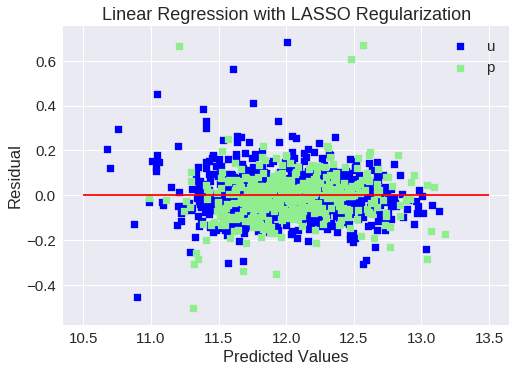

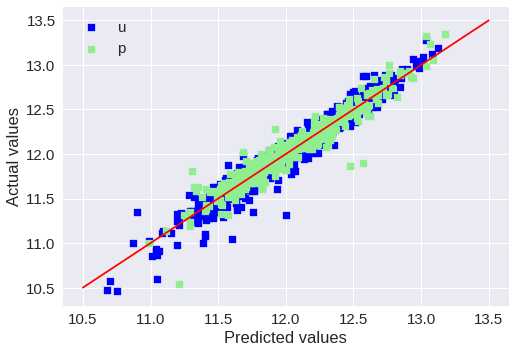

LASSO picked 136 features and eliminated other 159


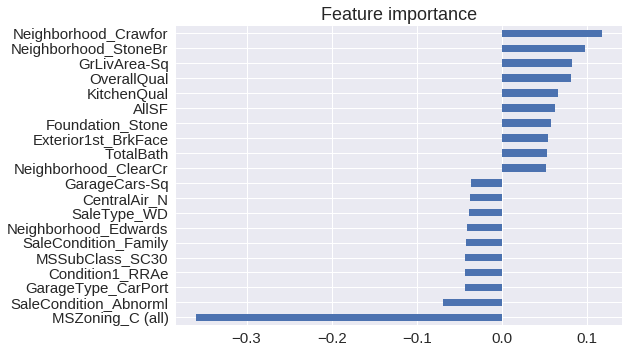

In [41]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,0.3, 0.6, 1],max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print('Best alpha: ' + str(alpha))

print('Searching for better value for alpha near above mentioned value.')
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)


# Residual plot
plt.scatter(y_train_las, y_train_las - y_train, c = 'blue', marker = 's', label = 'Training data')
plt.scatter(y_test_las, y_test_las - y_test, c = 'lightgreen', marker = 's', label = 'Test data')
plt.title('Linear Regression with LASSO Regularization')
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.legend('upper left')
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = 'blue', marker = 's', label = 'Training data')
plt.scatter(y_test_las, y_test, c = 'lightgreen', marker = 's', label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.legend('upper left')
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Feature importance
coefs = pd.Series(lasso.coef_, index=X_train.columns)
print('LASSO picked ' + str(sum(coefs != 0)) + ' features and eliminated other ' + str(sum(coefs == 0)))
imp_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])
imp_coefs.plot(kind = 'barh')
plt.title('Feature importance')
plt.show()

**4) Linear Regression with ElasticNet Regularization**

Best alpha: 0.0006
Best L1-ratio: 0.5
Searching for better values l1_ratio being centered around 0.5
Best alpha: 0.0006
Best L1-ratio: 0.525
Searching for better parameters with l1_ratio being fixed at 0.525 alpha values centered around 0.0006
Best alpha: 0.00057
Best L1-ratio: 0.525
ElasticNet RMSE on Training set : 0.11203878520249097
ElasticNet RMSE on Test set : 0.11178808881632898


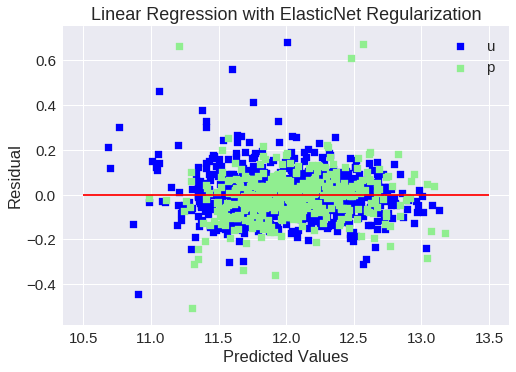

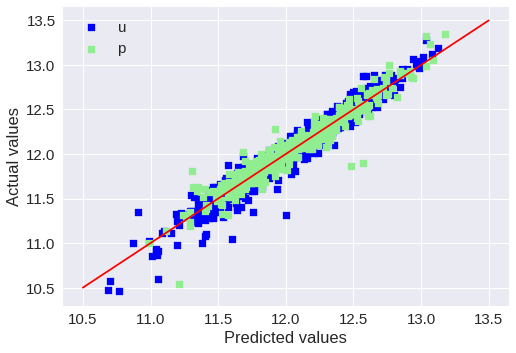

ElasticNet picked 145 features and eliminated other 150


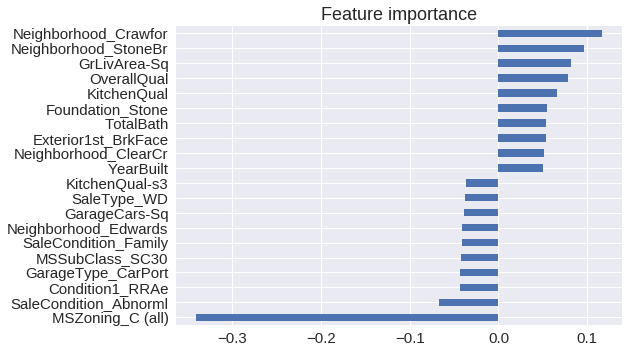

In [42]:
elasticNet = ElasticNetCV(
    alphas=[
        0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
        0.3, 0.6, 1, 3, 6
    ],
    l1_ratio=[0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
    max_iter=50000,
    cv=10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print('Best alpha: ' + str(alpha))
print('Best L1-ratio: ' + str(ratio))

print('Searching for better values l1_ratio being centered around ' +
      str(ratio))
elasticNet = ElasticNetCV(
    l1_ratio=[
        ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1,
        ratio * 1.15
    ],
    alphas=[
        0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
        0.3, 0.6, 1, 3, 6
    ],
    max_iter=50000,
    cv=10)
elasticNet.fit(X_train, y_train)
if elasticNet.l1_ratio_ > 1:
    elasticNet.l1_ratio_ = 1
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print('Best alpha: ' + str(alpha))
print('Best L1-ratio: ' + str(ratio))

print('Searching for better parameters with l1_ratio being fixed at ' +
      str(ratio) + ' alpha values centered around ' + str(alpha))
elasticNet = ElasticNetCV(
    l1_ratio=ratio,
    alphas=[
        alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8,
        alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1,
        alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4
    ],
    max_iter=50000,
    cv=10)

elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print('Best alpha: ' + str(alpha))
print('Best L1-ratio: ' + str(ratio))

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Residual plot
plt.scatter(
    y_train_ela,
    y_train_ela - y_train,
    c='blue',
    marker='s',
    label='Training data')
plt.scatter(
    y_test_ela,
    y_test_ela - y_test,
    c='lightgreen',
    marker='s',
    label='Test data')
plt.title('Linear Regression with ElasticNet Regularization')
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.legend('upper left')
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red")
plt.show()

# Plot predictions
plt.scatter(y_train_ela, y_train, c='blue', marker='s', label='Training data')
plt.scatter(y_test_ela, y_test, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.legend('upper left')
plt.plot([10.5, 13.5], [10.5, 13.5], c="red")
plt.show()

# Feature importance
coefs = pd.Series(elasticNet.coef_, index=X_train.columns)
print('ElasticNet picked ' + str(sum(coefs != 0)) +
      ' features and eliminated other ' + str(sum(coefs == 0)))
imp_coefs = pd.concat(
    [coefs.sort_values().head(10),
     coefs.sort_values().tail(10)])
imp_coefs.plot(kind='barh')
plt.title('Feature importance')
plt.show()